In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        self.c3 = nn.Conv2d(3, 64, 3, stride=2, padding=1)   # /2
        self.c4 = nn.Conv2d(64, 128, 3, stride=2, padding=1) # /4
        self.c5 = nn.Conv2d(128, 256, 3, stride=2, padding=1) # /8

    def forward(self, x):
        c3 = F.relu(self.c3(x))
        c4 = F.relu(self.c4(c3))
        c5 = F.relu(self.c5(c4))
        return c3, c4, c5

class SimpleFPN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lat3 = nn.Conv2d(64, 128, 1)
        self.lat4 = nn.Conv2d(128, 128, 1)
        self.lat5 = nn.Conv2d(256, 128, 1)

    def forward(self, c3, c4, c5):
        p5 = self.lat5(c5)
        p4 = self.lat4(c4) + F.interpolate(p5, scale_factor=2)
        p3 = self.lat3(c3) + F.interpolate(p4, scale_factor=2)
        return [p3, p4, p5]


class FCOSHead(nn.Module):
    def __init__(self, in_ch, num_classes):
        super().__init__()
        self.cls = nn.Conv2d(in_ch, num_classes, 3, padding=1)
        self.reg = nn.Conv2d(in_ch, 4, 3, padding=1)
        self.ctr = nn.Conv2d(in_ch, 1, 3, padding=1)

    def forward(self, x):
        cls = self.cls(x)
        reg = F.relu(self.reg(x))
        ctr = self.ctr(x)
        return cls, reg, ctr


class FCOS(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = SimpleBackbone()
        self.fpn = SimpleFPN()
        self.head = FCOSHead(128, num_classes)

    def forward(self, x):
        c3, c4, c5 = self.backbone(x)
        pyramids = self.fpn(c3, c4, c5)

        outputs = []
        for p in pyramids:
            outputs.append(self.head(p))
        return outputs


def generate_fcos_targets(gt_boxes, H, W):
    """
    gt_boxes: (N,4) [x1,y1,x2,y2] 画像座標
    H,W      : feature map size

    出力:
      cls_target: (H,W)  1=物体, 0=背景（簡易）
      reg_target: (H,W,4) l,t,r,b
      ctr_target: (H,W)
    """
    cls_target = torch.zeros(H, W)
    reg_target = torch.zeros(H, W, 4)
    ctr_target = torch.zeros(H, W)

    for box in gt_boxes:
        x1, y1, x2, y2 = box

        for y in range(H):
            for x in range(W):
                # ピクセル中心（簡易）
                px, py = x + 0.5, y + 0.5

                if x1 <= px <= x2 and y1 <= py <= y2:
                    l = px - x1
                    t = py - y1
                    r = x2 - px
                    b = y2 - py

                    cls_target[y, x] = 1
                    reg_target[y, x] = torch.tensor([l, t, r, b])

                    ctr_target[y, x] = torch.sqrt(
                        (min(l, r) / max(l, r)) *
                        (min(t, b) / max(t, b))
                    )

    return cls_target, reg_target, ctr_target

def decode_fcos(reg_preds):
    """
    reg_preds: (B,4,H,W) -> l,t,r,b
    return: BBox list（簡易）
    """
    B, _, H, W = reg_preds.shape
    boxes = []

    for b in range(B):
        for y in range(H):
            for x in range(W):
                l, t, r, b_ = reg_preds[b, :, y, x]
                cx, cy = x + 0.5, y + 0.5

                x1 = cx - l
                y1 = cy - t
                x2 = cx + r
                y2 = cy + b_

                boxes.append([x1, y1, x2, y2])

    return boxes


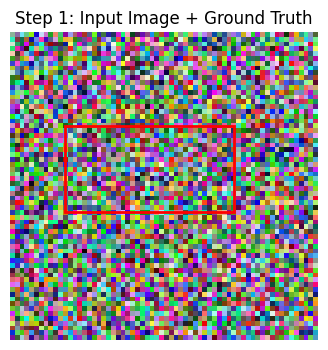

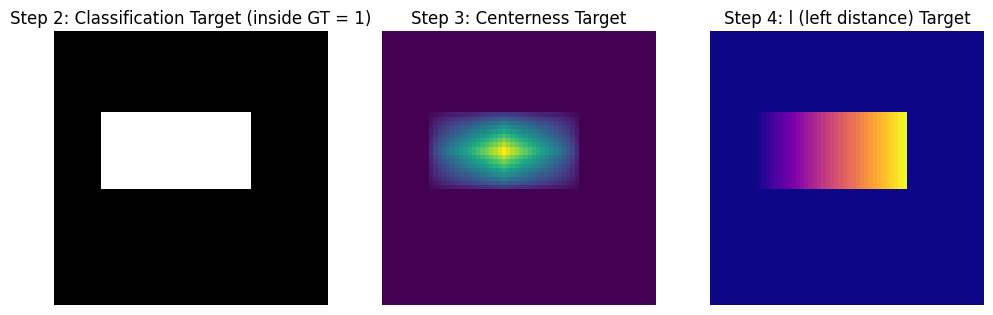

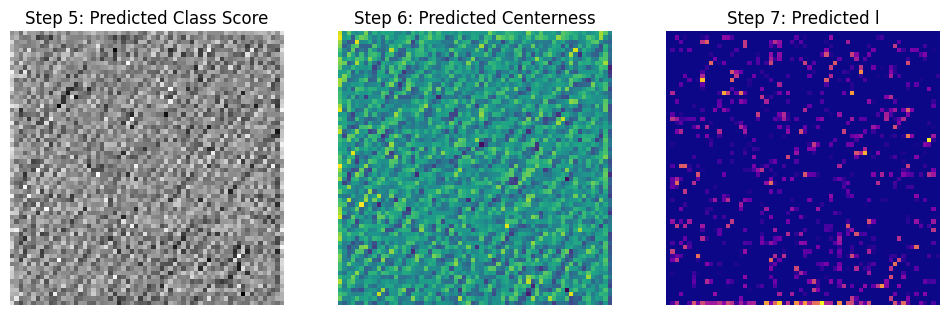

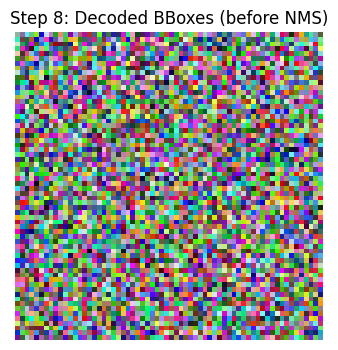

In [2]:
# FCOS 挙動をステップごとに可視化するデモコード
# - 疑似データ（ランダムGT）生成
# - FCOS教師信号生成
# - 推論（ランダム重み）
# - 各ステップを matplotlib で可視化
#
# 目的：
# 「アンカーなし」「点基準」「l,t,r,b 回帰」「centerness」の流れを“目で追う”

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# -----------------------------
# 0. 乱数固定（再現性）
# -----------------------------
torch.manual_seed(0)
np.random.seed(0)

# -----------------------------
# 1. 疑似画像 & GT 生成
# -----------------------------
IMG_H, IMG_W = 64, 64          # 小さくして可視化しやすく
NUM_GT = 1

# 疑似画像（中身は使わない。構造理解用）
image = np.random.rand(IMG_H, IMG_W, 3)

# ランダムGT（画像内に収まるよう制約）
x1 = np.random.randint(10, 25)
y1 = np.random.randint(10, 25)
x2 = np.random.randint(35, 55)
y2 = np.random.randint(35, 55)
gt_boxes = np.array([[x1, y1, x2, y2]], dtype=np.float32)

# -----------------------------
# 2. 可視化ユーティリティ
# -----------------------------
def show_image_with_boxes(img, boxes, title):
    fig, ax = plt.subplots(figsize=(4,4))
    ax.imshow(img)
    for (x1,y1,x2,y2) in boxes:
        ax.add_patch(Rectangle((x1,y1), x2-x1, y2-y1,
                               edgecolor="red", facecolor="none", linewidth=2))
    ax.set_title(title)
    ax.axis("off")
    plt.show()

# Step 1: GT表示
show_image_with_boxes(image, gt_boxes, "Step 1: Input Image + Ground Truth")

# -----------------------------
# 3. FCOS 教師信号生成
# -----------------------------
H, W = IMG_H, IMG_W

cls_target = np.zeros((H, W))
reg_target = np.zeros((H, W, 4))
ctr_target = np.zeros((H, W))

x1,y1,x2,y2 = gt_boxes[0]

for y in range(H):
    for x in range(W):
        px, py = x + 0.5, y + 0.5
        if x1 <= px <= x2 and y1 <= py <= y2:
            l = px - x1
            t = py - y1
            r = x2 - px
            b = y2 - py
            cls_target[y,x] = 1
            reg_target[y,x] = [l,t,r,b]
            ctr_target[y,x] = np.sqrt(
                (min(l,r)/max(l,r)) * (min(t,b)/max(t,b))
            )

# -----------------------------
# 4. 教師信号の可視化
# -----------------------------
fig, axs = plt.subplots(1,3, figsize=(12,4))
axs[0].imshow(cls_target, cmap="gray")
axs[0].set_title("Step 2: Classification Target (inside GT = 1)")
axs[1].imshow(ctr_target, cmap="viridis")
axs[1].set_title("Step 3: Centerness Target")
axs[2].imshow(reg_target[:,:,0], cmap="plasma")
axs[2].set_title("Step 4: l (left distance) Target")
for ax in axs: ax.axis("off")
plt.show()

# -----------------------------
# 5. 簡易 FCOS ネットワーク
# -----------------------------
class TinyFCOS(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = nn.Conv2d(3, 8, 3, padding=1)
        self.cls_head = nn.Conv2d(8, 1, 3, padding=1)
        self.reg_head = nn.Conv2d(8, 4, 3, padding=1)
        self.ctr_head = nn.Conv2d(8, 1, 3, padding=1)

    def forward(self, x):
        feat = F.relu(self.backbone(x))
        cls = torch.sigmoid(self.cls_head(feat))
        reg = F.relu(self.reg_head(feat))
        ctr = torch.sigmoid(self.ctr_head(feat))
        return cls, reg, ctr

model = TinyFCOS()

# -----------------------------
# 6. 推論（ランダム重み）
# -----------------------------
inp = torch.tensor(image).permute(2,0,1).unsqueeze(0).float()
cls_pred, reg_pred, ctr_pred = model(inp)

cls_pred = cls_pred.detach().numpy()[0,0]
ctr_pred = ctr_pred.detach().numpy()[0,0]
reg_pred = reg_pred.detach().numpy()[0]

# -----------------------------
# 7. 推論結果の可視化
# -----------------------------
fig, axs = plt.subplots(1,3, figsize=(12,4))
axs[0].imshow(cls_pred, cmap="gray")
axs[0].set_title("Step 5: Predicted Class Score")
axs[1].imshow(ctr_pred, cmap="viridis")
axs[1].set_title("Step 6: Predicted Centerness")
axs[2].imshow(reg_pred[0], cmap="plasma")
axs[2].set_title("Step 7: Predicted l")
for ax in axs: ax.axis("off")
plt.show()

# -----------------------------
# 8. decode → BBox生成（score閾値）
# -----------------------------
TH = 0.5
pred_boxes = []

for y in range(H):
    for x in range(W):
        score = cls_pred[y,x] * ctr_pred[y,x]
        if score > TH:
            l,t,r,b = reg_pred[:,y,x]
            cx, cy = x + 0.5, y + 0.5
            pred_boxes.append([cx-l, cy-t, cx+r, cy+b])

# Step 8: 推論BBox表示
show_image_with_boxes(image, pred_boxes, "Step 8: Decoded BBoxes (before NMS)")
